In [1]:
#import models
import numpy as np
import h5py
import sys, os
import rospy
import rosbag
import math
from scipy.interpolate import interp1d
import h5py
import matplotlib.pylab as plt

#sys.path.insert(0, '/media/abdulla/Seagate Expansion Drive/DVS research/DATA/contact estimation/')
from EventPreProcess import EventPreProcess
from std_msgs.msg import Float64, Bool
from geometry_msgs.msg import Pose, Vector3, PoseStamped
from sensor_msgs.msg import Image
from cv_bridge import CvBridge

In [2]:
#parameters of processing
frequency = 10 #Hz
bag_file_name = 'tactile_sensing_data/17_point_centered.bag'
h5_file_name = 'frame_17_point_centered.hdf5'
examples_per_edge = 1

In [3]:
bag_file = rosbag.Bag(bag_file_name)

frames = []
frames_ts = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []
bridge = CvBridge()


#generate labels
possible_angle = [0.1, 0.25]
N_examples = 9
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * math.cos(theta)
        ry = phi * math.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

print(list_of_rotations)


KeyboardInterrupt: 

In [4]:
#parse rosbag

for topic, msg, t in bag_file.read_messages(topics=['/contact_status', '/dvs/image_raw', '/contact_angle']):
    if topic == '/dvs/image_raw':     
        cv_image = bridge.imgmsg_to_cv2(msg, desired_encoding='passthrough')
        if np.shape(cv_image) == (260, 346, 3):    
            frames.append(cv_image)
            frames_ts.append(t.to_nsec())
        else:
            print("wrong size:", np.shape(cv_image))
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        if (len(contact_status) > 1):
            if (contact_status[-1] == True):
                best_rot_diff = 100
                best_rot_idx = 1
                i = 1
                for rot in list_of_rotations:
                    diff_vals = np.sqrt( np.power(rot[0] - msg.x, 2) +  np.power(rot[1] - msg.y, 2) + np.power(rot[2] - msg.z, 2) )
                    if best_rot_diff > diff_vals:
                        best_rot_diff = diff_vals
                        best_rot_idx = i
                    i = i + 1

                contact_case.append(best_rot_idx)
                contact_case_ts.append(t.to_nsec())
            else:
                contact_case.append(0)
                contact_case_ts.append(t.to_nsec())
        else:
            contact_case.append(0)
            contact_case_ts.append(t.to_nsec())
bag_file.close()

('wrong size:', (250, 346, 3))
('wrong size:', (250, 346, 3))
('wrong size:', (260, 12, 3))
('wrong size:', (260, 12, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 344, 3))
('wrong size:', (260, 344, 3))
('wrong size:', (258, 346, 3))
('wrong size:', (258, 346, 3))


In [5]:
#interpolate contact status to meet proper time
f = interp1d(contact_case_ts, contact_case, kind='previous')
frame_ts_start_idx = np.min(np.nonzero([i > np.min(contact_case_ts) for i in frames_ts]))
frame_ts_end_idx = np.max(np.nonzero([i < np.max(contact_case_ts) for i in frames_ts]))
contact_case_ts_int = frames_ts[frame_ts_start_idx:frame_ts_end_idx]
contact_case_int = f(contact_case_ts_int)
frames_int = np.copy(frames[frame_ts_start_idx:frame_ts_end_idx])

In [6]:
del frames

In [7]:
import gc
gc.collect()

0

In [8]:
print(np.shape(frames_int))

(5447, 260, 346, 3)


2
5449


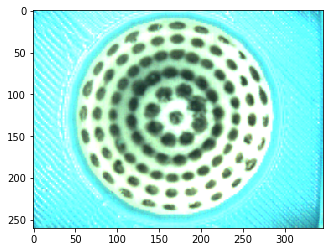

In [9]:
plt.imshow(frames_int[150])
print(frame_ts_start_idx)
print(frame_ts_end_idx)
plt.show()

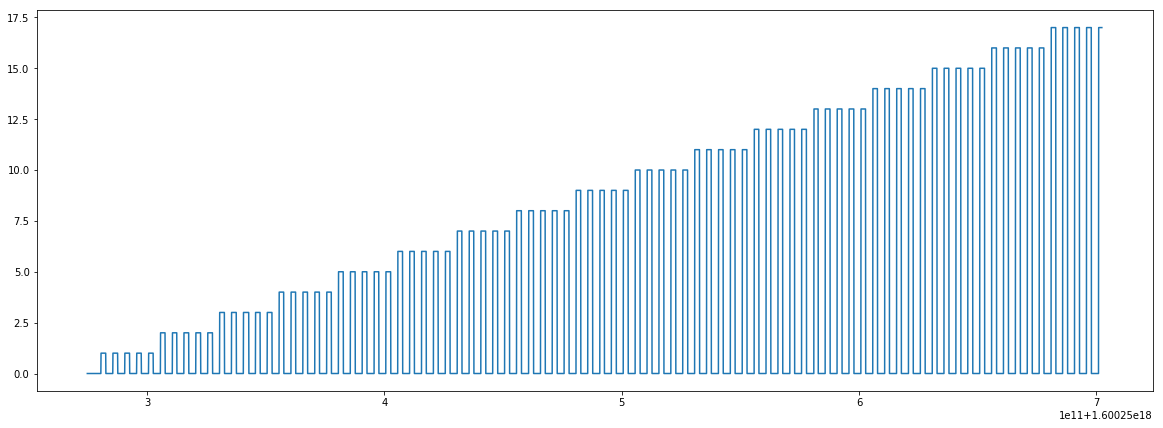

5447
5447


In [10]:
plt.figure(figsize=(20,7))
plt.plot(contact_case_ts_int, contact_case_int)
plt.show()
print(len(contact_case_ts_int))
print(len(frames_int))

In [2]:
del EventPreProcess
import EventPreProcess
reload(EventPreProcess)
from EventPreProcess import EventPreProcess

ImportError: cannot import name reload

In [11]:
#Generate frames, crop and and store in h5 file
hf = h5py.File(h5_file_name, 'w')
hf.create_dataset('contact_status', data=contact_case_int)
hf.create_dataset('time_steps', data=contact_case_ts_int)

set_size = 1000

for i in range(0, len(contact_case_ts_int), set_size):
    start_idx=i
    end_idx=min([len(contact_case_ts_int), i+set_size])

    cropped_image = EventPreProcess.cropFrames(frames_int[start_idx:end_idx], circle_center=(170, 125), circle_rad=115, im_channels=3, expand_dims=False)

    #write data
    if i==0:
        print(np.shape(cropped_image))
        hf.create_dataset('frames', data=cropped_image, maxshape=(None,None, None, None))
    else:
        hf['frames'].resize(len(hf['frames']) + len(cropped_image), axis=0)
        hf["frames"][-len(cropped_image):] = cropped_image
    del cropped_image
    
del frames_int
hf.close()

(1000, 260, 346, 3)


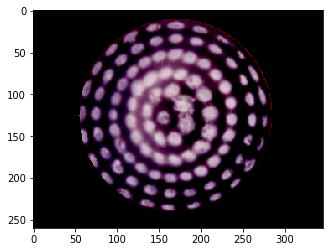

13.0
[17]


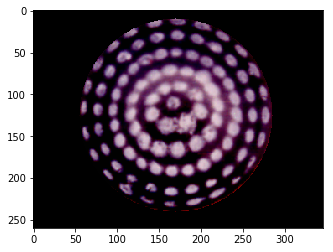

In [12]:
hf = h5py.File(h5_file_name, 'r+')
desired_status = 13
encounter = np.min(np.nonzero([i == desired_status for i in hf['contact_status']]))+10

original_image = hf['frames'][encounter]
original_contact_status = hf['contact_status'][encounter]
rot_90_image = EventPreProcess.rotateFrames([original_image], circle_center=(170, 125), rotate_angle=270)
rot_90_contact_status = EventPreProcess.updateContactStatus([original_contact_status], list_of_rotations, 270)

plt.imshow(original_image)
plt.show()
print(original_contact_status)
print(rot_90_contact_status)
plt.imshow(rot_90_image[0])
plt.show()
hf.close()

In [4]:
hf = h5py.File(h5_file_name, 'r+')
del hf['frames_augmented']
del hf['contact_status_augmented']
hf.close()

KeyError: "Couldn't delete link (callback link pointer is NULL (specified link may be '.' or not exist))"

In [5]:
#Augment images with rotation
hf = h5py.File(h5_file_name, 'r+')
set_size = 300

for i in range(0, len(hf['frames']), set_size):
    start_idx=i
    end_idx=min([len(hf['frames']), i+set_size])

    original_image = hf['frames'][start_idx:end_idx]
    original_contact_status = hf['contact_status'][start_idx:end_idx]

    rot_90_image = EventPreProcess.rotateFrames(original_image, circle_center=(170, 125), rotate_angle=90)
    rot_90_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 90)

    rot_180_image = EventPreProcess.rotateFrames(original_image, circle_center=(170, 125), rotate_angle=180)
    rot_180_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 180)

    rot_270_image = EventPreProcess.rotateFrames(original_image, circle_center=(170, 125), rotate_angle=270)
    rot_270_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 270)


    #write data
    if i==0:
        hf.create_dataset('frames_augmented', data=np.concatenate((original_image, rot_90_image, rot_180_image, rot_270_image), axis=0), maxshape=(None,None, None, None))
        hf.create_dataset('contact_status_augmented', data=np.concatenate((original_contact_status, rot_90_contact_status, rot_180_contact_status, rot_270_contact_status), axis=0), maxshape=(None,))
    else:
        hf['frames_augmented'].resize(len(hf['frames_augmented']) + 4*len(original_image), axis=0)
        hf["frames_augmented"][-4*len(original_image):] = np.concatenate((original_image, rot_90_image, rot_180_image, rot_270_image), axis=0)

        hf['contact_status_augmented'].resize(len(hf['contact_status_augmented']) + 4*len(original_contact_status), axis=0)
        hf["contact_status_augmented"][-4*len(original_contact_status):] = np.concatenate((original_contact_status, rot_90_contact_status, rot_180_contact_status, rot_270_contact_status), axis=0)
    
    del rot_270_image, rot_180_image, rot_90_image, original_image
    del rot_270_contact_status, rot_180_contact_status, rot_90_contact_status, original_contact_status

hf.close()

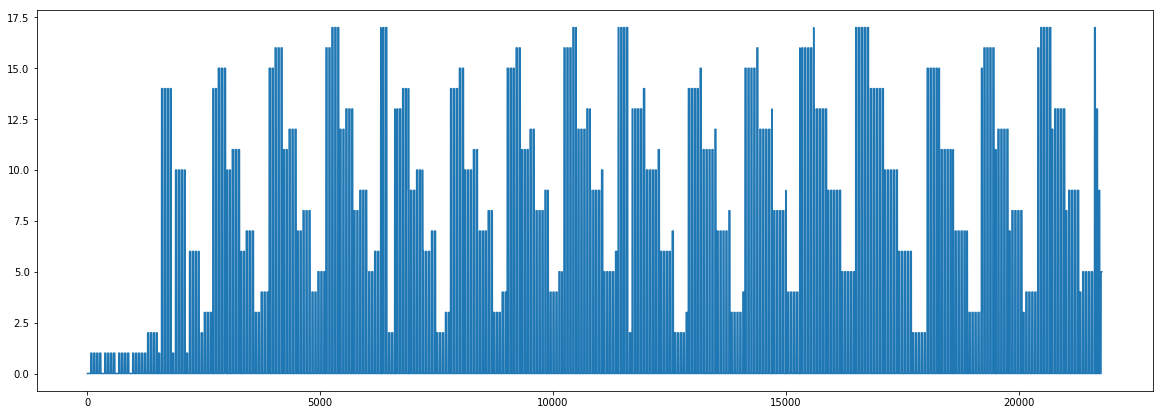

In [6]:
hf = h5py.File(h5_file_name, 'r')
plt.figure(figsize=(20,7))
plt.plot(hf["contact_status_augmented"])
plt.show()
hf.close()

In [55]:
print(np.array(list_of_rotations[2][0:2]))
rotation_angle = 90
rot_mat = np.array( [ [math.cos(rotation_angle*math.pi/180), math.sin(rotation_angle*math.pi/180)], [-math.sin(rotation_angle*math.pi/180), math.cos(rotation_angle*math.pi/180)] ] )
print(rot_mat)
print(np.matmul(rot_mat, list_of_rotations[2][0:2] ))

[0.1767767 0.1767767]
[[ 6.123234e-17  1.000000e+00]
 [-1.000000e+00  6.123234e-17]]
[ 0.1767767 -0.1767767]


In [7]:
hf = h5py.File(h5_file_name, 'r+')
print('number of total frames: {}'.format(len(hf['contact_status_augmented'])))
hf.close()

number of total frames: 21788


In [11]:
#Find rise/drop time and create windows accordingle
hf = h5py.File(h5_file_name, 'r+')
edge_locations = np.where(np.diff(hf['contact_status_augmented'])>0)
edge_locations = np.array(edge_locations)[0].tolist()
print(edge_locations)
hf.close()

[73, 137, 201, 265, 373, 437, 501, 565, 673, 737, 801, 865, 973, 1037, 1101, 1165, 1229, 1293, 1357, 1419, 1483, 1529, 1593, 1657, 1719, 1783, 1829, 1893, 1957, 2019, 2083, 2129, 2193, 2257, 2319, 2383, 2447, 2511, 2575, 2639, 2699, 2747, 2811, 2875, 2939, 2999, 3047, 3111, 3175, 3239, 3299, 3347, 3411, 3475, 3539, 3604, 3667, 3731, 3795, 3859, 3904, 3967, 4031, 4095, 4159, 4204, 4267, 4331, 4395, 4459, 4504, 4567, 4631, 4695, 4759, 4823, 4887, 4950, 5014, 5078, 5123, 5187, 5250, 5314, 5378, 5423, 5487, 5550, 5614, 5678, 5723, 5787, 5850, 5914, 5978, 6042, 6105, 6169, 6233, 6297, 6299, 6342, 6405, 6469, 6533, 6597, 6599, 6642, 6705, 6769, 6833, 6897, 6942, 7005, 7069, 7133, 7197, 7261, 7325, 7389, 7453, 7499, 7561, 7625, 7689, 7753, 7799, 7861, 7925, 7989, 8053, 8099, 8161, 8225, 8289, 8353, 8416, 8480, 8542, 8606, 8671, 8716, 8780, 8842, 8906, 8971, 9016, 9080, 9142, 9206, 9271, 9316, 9380, 9442, 9506, 9571, 9635, 9698, 9762, 9826, 9889, 9935, 9998, 10062, 10126, 10189, 10235, 10298, 

8.0


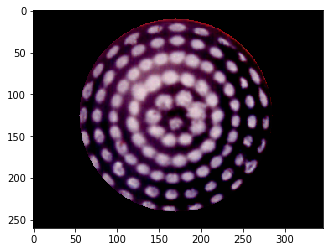

In [14]:
#Visualize events at switching states
hf = h5py.File(h5_file_name, 'r+')
indx = 9637
plt.imshow(hf['frames_augmented'][indx])
print(hf['contact_status_augmented'][indx])
plt.show
hf.close()

[13156, 512, 506, 513, 509, 502, 506, 513, 509, 502, 506, 513, 509, 502, 506, 513, 509, 502]


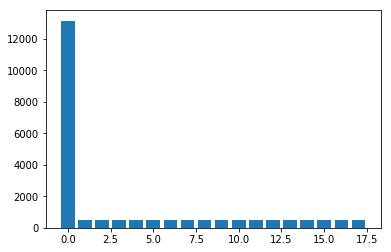

In [17]:
#analyze classes
hf = h5py.File(h5_file_name, 'r+')
counter = [0] * 18

for i in range(len(hf['contact_status_augmented'])):
    idx = int(hf['contact_status_augmented'][i])
    counter[idx] = counter[idx] + 1

print(counter)
plt.bar(range(0,18),counter)
hf.close()

In [18]:
#Equalize representation of classes
hf = h5py.File(h5_file_name, 'r+')
def equalize_representation(hf_file, class_counter, n_classes=6):
    for i in range(1, len(hf_file['frames_augmented'])):
        idx = int(hf['contact_status_augmented'][i])
        
        if (np.random.rand() < (float(min(counter[1:])) / counter[idx])):
            if 'frames_augmented_equalized' in hf_file.keys():
                hf_file['frames_augmented_equalized'].resize(len(hf_file['frames_augmented_equalized']) + 1, axis=0)
                hf_file["frames_augmented_equalized"][len(hf_file['frames_augmented_equalized'])-1] = hf_file['frames_augmented'][i]

                hf_file['contact_status_augmented_equalized'].resize(len(hf_file['contact_status_augmented_equalized']) + 1, axis=0)
                hf_file["contact_status_augmented_equalized"][len(hf_file['contact_status_augmented_equalized'])-1] = hf_file['contact_status_augmented'][i]
            else:
                hf_file.create_dataset('frames_augmented_equalized', data=[hf_file['frames_augmented'][i]], maxshape=(None,None, None, None))
                hf_file.create_dataset('contact_status_augmented_equalized', data=[hf_file['contact_status_augmented'][i]], maxshape=(None,))

equalize_representation(hf, counter)

[3289, 128, 127, 132, 125, 128, 126, 128, 129, 127, 128, 124, 126, 126, 125, 129, 129, 121]


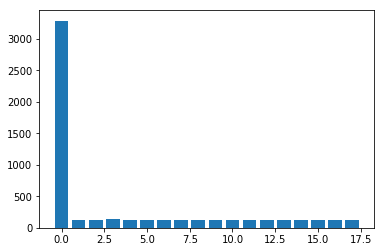

In [14]:
#analyze classes
hf = h5py.File(h5_file_name, 'r+')
counter = [0] * 18

for i in range(len(hf['contact_status'])):
    idx = int(hf['contact_status'][i])
    counter[idx] = counter[idx] + 1

print(counter)
plt.bar(range(0,18),counter)
hf.close()

In [15]:
#Equalize representation of classes
hf = h5py.File(h5_file_name, 'r+')
def equalize_representation(hf_file, class_counter, n_classes=6):
    for i in range(1, len(hf_file['frames'])):
        idx = int(hf['contact_status'][i])
        
        if (np.random.rand() < (float(min(counter[1:])) / counter[idx])):
            if 'frames_augmented_equalized' in hf_file.keys():
                hf_file['frames_augmented_equalized'].resize(len(hf_file['frames_augmented_equalized']) + 1, axis=0)
                hf_file["frames_augmented_equalized"][len(hf_file['frames_augmented_equalized'])-1] = hf_file['frames'][i]

                hf_file['contact_status_augmented_equalized'].resize(len(hf_file['contact_status_augmented_equalized']) + 1, axis=0)
                hf_file["contact_status_augmented_equalized"][len(hf_file['contact_status_augmented_equalized'])-1] = hf_file['contact_status'][i]
            else:
                hf_file.create_dataset('frames_augmented_equalized', data=[hf_file['frames'][i]], maxshape=(None,None, None, None))
                hf_file.create_dataset('contact_status_augmented_equalized', data=[hf_file['contact_status'][i]], maxshape=(None,))

equalize_representation(hf, counter)

[127, 122, 122, 118, 118, 122, 121, 123, 119, 125, 124, 117, 122, 123, 120, 120, 126, 121]


<Container object of 18 artists>

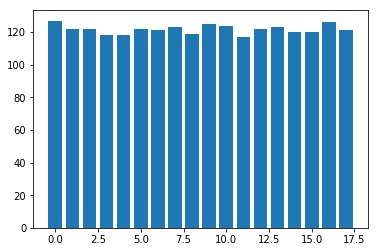

In [16]:
new_counter = [0] * 18

for i in range(len(hf['contact_status_augmented_equalized'])):
    idx = int(hf['contact_status_augmented_equalized'][i])
    new_counter[idx] = new_counter[idx] + 1

print(new_counter)
plt.bar(range(0,18),new_counter)

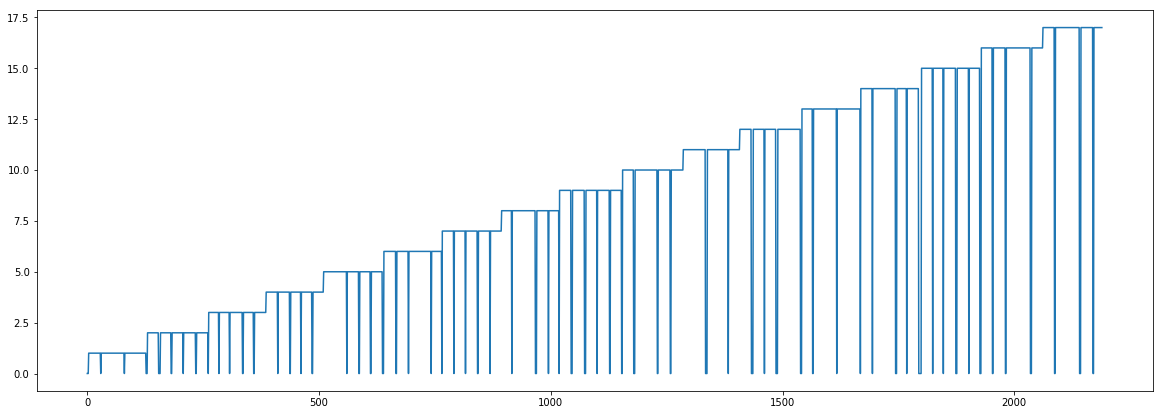

In [17]:
hf = h5py.File(h5_file_name, 'r')
plt.figure(figsize=(20,7))
plt.plot(hf["contact_status_augmented_equalized"])
plt.show()
hf.close()

9.0


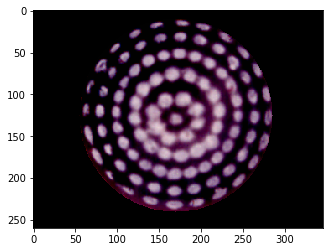

In [25]:
#Visualize events at switching states
hf = h5py.File(h5_file_name, 'r+')
indx = 9000
plt.imshow(hf['frames_augmented_equalized'][indx])
print(hf['contact_status_augmented_equalized'][indx])
plt.show
hf.close()

In [20]:
print(len(hf['contact_status_augmented_equalized']))

9036


In [20]:
hf.close()

[5173, 5235, 5299, 5363, 5428]


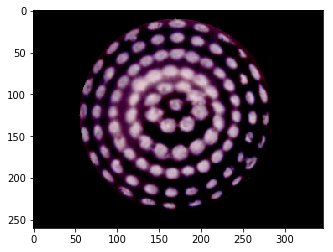

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


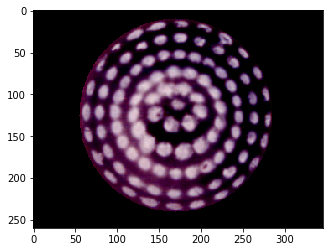

In [68]:
#compare augmented data with regular images
hf = h5py.File(h5_file_name, 'r')
desired_class = 17
idx = 0
increment = 10

edge_locations = np.where(np.multiply(np.diff(hf['contact_status'])>0, np.equal(np.array(hf['contact_status']), desired_class * np.ones(shape=np.shape(hf['contact_status'])))[1:] ))
edge_locations = np.array(edge_locations)[0].tolist()
print(edge_locations)

plt.imshow(hf['frames'][edge_locations[idx]+increment])
plt.show()

idx = 5

edge_locations_augmented = np.where(np.multiply(np.diff(hf['contact_status_augmented'])>0, np.equal(np.array(hf['contact_status_augmented']), desired_class * np.ones(shape=np.shape(hf['contact_status_augmented'])))[1:] ))
edge_locations_augmented = np.array(edge_locations_augmented)[0].tolist()
print(edge_locations_augmented)

plt.imshow(hf['frames_augmented'][edge_locations_augmented[idx]+increment])
plt.show()

hf.close()

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


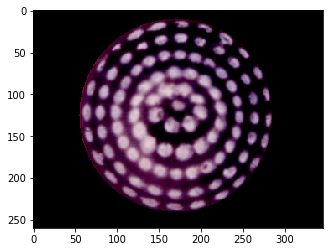

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


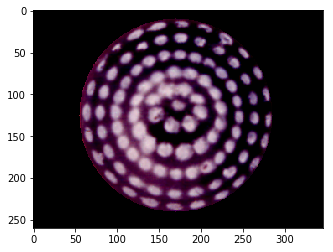

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


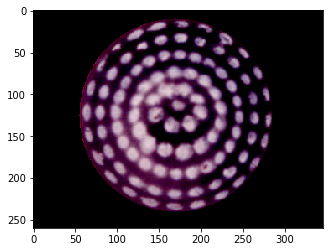

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


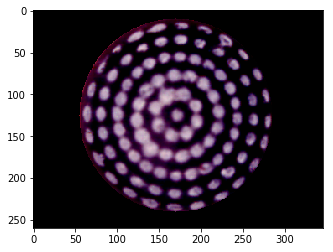

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


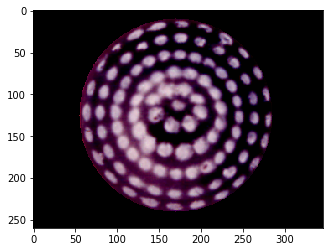

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


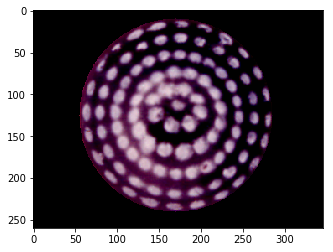

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


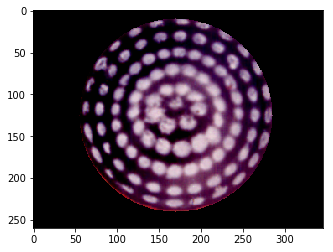

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


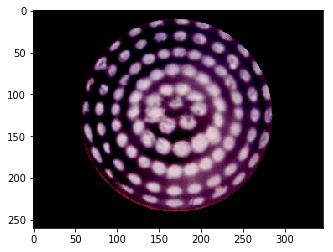

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


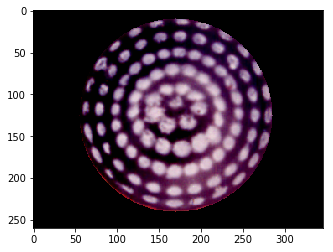

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


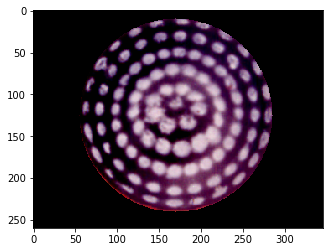

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


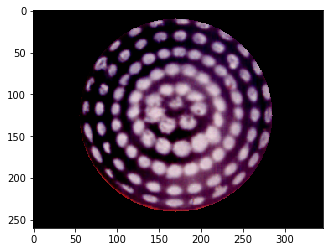

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


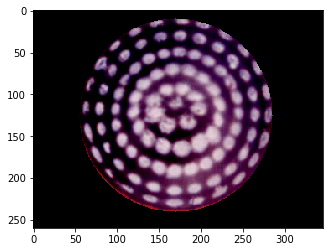

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


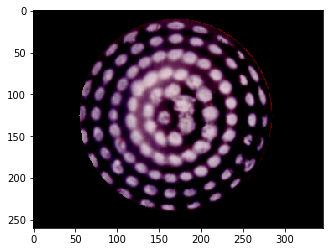

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


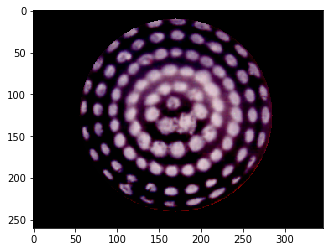

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


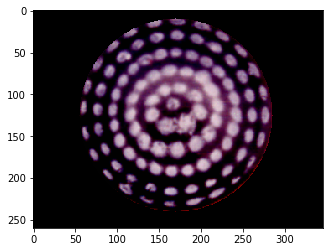

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


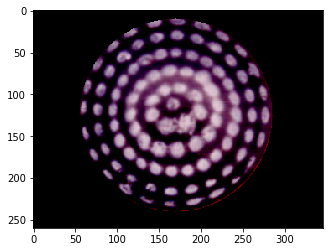

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


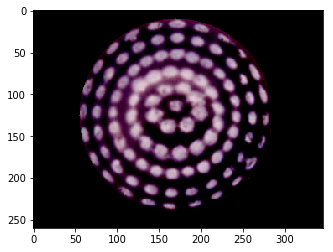

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


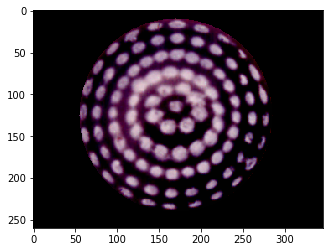

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


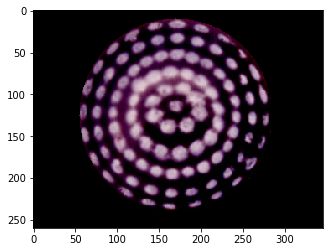

[5250, 5314, 5378, 6299, 6342, 6405, 10426, 10489, 11399, 11454, 11514, 11578, 15597, 16499, 16558, 16622, 16686, 16750, 20473, 20535, 20599, 20663, 21628]


In [72]:
#compare augmented data with regular images
hf = h5py.File(h5_file_name, 'r')
desired_class = 17
increment = 5

for idx in range(len(edge_locations_augmented)):

    edge_locations_augmented = np.where(np.multiply(np.diff(hf['contact_status_augmented'])>0, np.equal(np.array(hf['contact_status_augmented']), desired_class * np.ones(shape=np.shape(hf['contact_status_augmented'])))[1:] ))
    edge_locations_augmented = np.array(edge_locations_augmented)[0].tolist()
    print(edge_locations_augmented)

    plt.imshow(hf['frames_augmented'][edge_locations_augmented[idx]+increment])
    plt.show()

hf.close()

In [33]:
print(np.mean(hf['event_images'][:,:,:,0]))
print(np.std(hf['event_images'][:,:,:,0]))
print(np.max(hf['event_images'][:,:,:,0]))
print(np.min(hf['event_images'][:,:,:,0]))


0.0008835273
0.031460017
21.0
0.0
